<a href="https://colab.research.google.com/github/yequalsmxplusc/project/blob/main/CHT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pymoo pyswarm openpyxl scikit-learn matplotlib seaborn torch pandas numpy

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 534.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 854.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.4 MB/s eta 0:00:00
   

In [2]:
# Import all the necessary libraries for data handling, model building,
# optimization, and evaluation.
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pyswarm import pso

# Set random seeds for reproducibility across runs.
np.random.seed(42)
torch.manual_seed(42)

# Set the device for PyTorch (GPU if available, otherwise CPU).
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
def load_data(data_path):
    """
    Load data file (CSV or Excel) without time-series specific processing.
    Handles both .csv and .xlsx extensions.
    """
    if data_path.endswith('.csv'):
        return pd.read_csv(data_path, encoding='latin1')
    else:
        return pd.read_excel(data_path, engine='openpyxl')

def load_and_preprocess_data(data_path, test_ratio=0.2, seq_length=10):
    """
    Enhanced data loading and preprocessing with comprehensive validation.
    This function can handle both time-series data (with a 'time' column)
    and optimization result files (which might not have 'time').
    """
    try:
        # 1. Data Loading with Validation
        data = load_data(data_path)

        # Validate expected columns (case-insensitive check)
        expected_columns = {
            'time': 'Time index',
            'aspect_ratio': 'Geometry parameter',
            'liquid_frac': 'Phase change progress',
            'Nu': 'Nusselt number',
            'T_pcm': 'PCM temperature',
            'T_battery': 'Battery temperature (target)'
        }

        # Check for missing critical columns
        missing_cols = [col for col in expected_columns if col.lower() not in [c.lower() for c in data.columns]]
        if missing_cols:
            available_cols = "\n- " + "\n- ".join(data.columns)
            raise ValueError(
                f"Missing {len(missing_cols)} critical column(s) in {data_path}:\n"
                f"Missing: {missing_cols}\n"
                f"Available columns:{available_cols}"
            )

        # 2. Data Quality Checks
        # Check for any null values in the entire DataFrame
        if data.isnull().sum().sum() > 0:
            null_cols = data.columns[data.isnull().any()].tolist()
            raise ValueError(f"Null values found in columns: {null_cols}")

        # Ensure 'time' column is numeric or convertible
        if not pd.api.types.is_numeric_dtype(data['time']):
            try:
                data['time'] = pd.to_numeric(data['time'])
            except:
                raise ValueError("Time column must be convertible to numeric")

        # 3. Core Processing (for time-series data)
        data = data.sort_values('time')

        # Enhanced rolling mean with dynamic window for 'liquid_frac'
        # Adaptive window size to prevent issues with small datasets
        window_size = min(5, len(data)//10)
        data['liquid_frac_rolling'] = (
            data['liquid_frac']
            .rolling(window=window_size, min_periods=1, center=True)
            .mean()
        )

        # 4. Train-Test Split with Temporal Preservation
        split_idx = int(len(data) * (1 - test_ratio))
        train_data = data.iloc[:split_idx]
        test_data = data.iloc[split_idx:]

        # 5. Sequence Creation with Safety Checks
        def create_sequences(df):
            sequences, targets = [], []
            features = ['aspect_ratio', 'liquid_frac', 'Nu', 'T_pcm']
            target_col = 'T_battery' # Target column name

            # Verify all feature columns exist in the DataFrame
            missing_features = [f for f in features if f not in df.columns]
            if missing_features:
                raise ValueError(f"Missing features: {missing_features}")

            # Create sequences of input features and corresponding target values
            for i in range(len(df) - seq_length):
                seq = df.iloc[i:i+seq_length]
                sequences.append(seq[features].values)
                targets.append(seq[target_col].iloc[-1]) # Get the last target value in the sequence

            # Ensure sequences were created successfully
            if not sequences:
                raise ValueError(
                    f"Insufficient data for sequence length {seq_length}. "
                    f"Available: {len(df)} samples"
                )

            return np.array(sequences), np.array(targets).reshape(-1, 1) # Reshape targets for consistency

        X_train, y_train = create_sequences(train_data)
        X_test, y_test = create_sequences(test_data)

    except Exception as e:
        print(f"\n{' ERROR ':-^60}")
        print(f"Failed processing {data_path}")
        print(f"Error: {str(e)}")
        print(f"\nDebugging Info:")
        if 'data' in locals():
            print(f"- Shape: {data.shape}")
            print(f"- Columns: {data.columns.tolist()}")
            if 'time' in data.columns:
                print(f"- Time range: {data['time'].min()} to {data['time'].max()}")
        print('-'*60)
        raise # Re-raise the exception after printing debug info

    # 6. Smart Normalization
    def normalize(X, y):
        """
        Handles edge cases in normalization (e.g., constant columns).
        Calculates mean and standard deviation for X and y separately.
        """
        # Calculate mean and std for X. Handle 3D (sequences) or 2D (single samples)
        X_mean = np.nanmean(X, axis=(0, 1)) if X.ndim == 3 else np.nanmean(X, axis=0)
        X_std = np.nanstd(X, axis=(0, 1)) if X.ndim == 3 else np.nanstd(X, axis=0)

        # Handle cases where std is zero (constant features) to avoid division by zero
        X_std[X_std == 0] = 1

        # Calculate mean and std for y (targets)
        y_mean, y_std = np.nanmean(y), np.nanstd(y)
        # Handle constant targets
        y_std = 1 if y_std == 0 else y_std

        # Apply normalization
        X_norm = (X - X_mean) / (X_std + 1e-8)
        y_norm = (y - y_mean) / (y_std + 1e-8)

        return X_norm, y_norm, (X_mean, X_std, y_mean, y_std)

    # Normalize training data to get statistics, then apply to test data
    X_train_norm, y_train_norm, norm_stats = normalize(X_train, y_train)
    X_test_norm, y_test_norm, _ = normalize(X_test, y_test) # Use train stats for test data

    return X_train_norm, X_test_norm, y_train_norm, y_test_norm, norm_stats

def augment_data(X, y, norm_stats, noise_factor=0.01, temp_threshold=70):
    """
    Enhanced data augmentation with temperature-based oversampling.
    Adds noise and oversamples high-temperature instances to improve model
    performance in critical regions.
    """
    # Denormalize y to actual temperatures using provided norm_stats
    y_actual = y * norm_stats[3] + norm_stats[2]

    # Add standard noise to X (features)
    X_noisy = X + noise_factor * np.random.randn(*X.shape)
    y_noisy = y.copy()

    # Oversample high-temperature cases
    high_temp_idx = np.where(y_actual > temp_threshold)[0]
    if len(high_temp_idx) > 0:
        X_high = X[high_temp_idx]
        y_high = y[high_temp_idx]

        # Create extra noisy versions of high-temp samples (3x oversampling)
        for _ in range(3):
            X_high_noisy = X_high + (noise_factor*2) * np.random.randn(*X_high.shape)
            X_noisy = np.vstack([X_noisy, X_high_noisy])
            y_noisy = np.vstack([y_noisy, y_high])

    # Combine original and augmented data
    return np.vstack([X, X_noisy]), np.vstack([y, y_noisy])

In [4]:
class EnhancedPINN(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super(EnhancedPINN, self).__init__()
        # Main LSTM layer for sequential data processing
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2, # Two LSTM layers for deeper feature extraction
            batch_first=True, # Input and output tensors are provided as (batch, seq, feature)
            dropout=0.2 # Dropout for regularization to prevent overfitting
        )

        # Auxiliary branch to specifically handle high-temperature related features.
        # It takes a flattened sequence as input.
        self.high_temp_branch = nn.Sequential(
            nn.Linear(input_size * 10, 128),  # Input size is input_features * seq_length (assuming seq_length=10)
            nn.ReLU(), # Activation function
            nn.Dropout(0.2), # Dropout for regularization
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32) # Output size of the auxiliary branch
        )

        # Enhanced prediction head that combines outputs from LSTM and auxiliary branch.
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + 32, 128), # Input is concatenation of LSTM hidden state and aux_out
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1) # Final output is a single temperature prediction
        )

    def forward(self, x):
        # Ensure the input tensor has the correct shape (batch, seq_length, input_size)
        if x.dim() == 2:
            x = x.unsqueeze(0) # Add batch dimension if it's missing (for single sample inference)

        # Process through the main LSTM branch
        lstm_out, _ = self.lstm(x)
        lstm_last = lstm_out[:, -1, :] # Get the hidden state of the last time step

        # Process through the auxiliary high-temperature branch
        batch_size = x.size(0)
        # Flatten the input sequence for the auxiliary branch
        flat_seq = x.reshape(batch_size, -1)
        aux_out = self.high_temp_branch(flat_seq)

        # Concatenate outputs from both branches
        combined = torch.cat([lstm_last, aux_out], dim=1)

        # Final prediction through the fully connected layers
        return self.fc(combined)

In [5]:
class TemperatureWeightedMSELoss(nn.Module):
    def __init__(self, norm_stats, threshold=70.0, weight_factor=5.0):
        super().__init__()
        # Register normalization statistics as buffers so they are part of the model's state_dict
        self.register_buffer('y_mean', torch.tensor(norm_stats[2], dtype=torch.float32))
        self.register_buffer('y_std', torch.tensor(norm_stats[3], dtype=torch.float32))
        self.threshold = threshold
        self.weight_factor = weight_factor

    def forward(self, pred, target):
        # Denormalize predictions and targets to actual temperature values for weighting
        pred_actual = pred * self.y_std + self.y_mean
        target_actual = target * self.y_std + self.y_mean

        # Calculate the base Mean Squared Error (MSE) using normalized values
        base_loss = F.mse_loss(pred, target)

        # Create a weight tensor, initially all ones
        weights = torch.ones_like(target_actual)
        # Identify samples where the actual temperature is above the critical threshold
        above_threshold = target_actual > self.threshold
        # Apply a higher weight to these critical samples
        weights[above_threshold] = self.weight_factor

        # Calculate the weighted MSE loss
        weighted_loss = (weights * (pred - target)**2).mean()

        # Combine the weighted loss and base MSE loss with a predefined ratio
        # This ensures that while high-temperature errors are prioritized,
        # overall prediction accuracy is also considered.
        return 0.7 * weighted_loss + 0.3 * base_loss

In [6]:
class BatteryCoolingProblem(Problem):
    def __init__(self, model, X_train, y_train):
        # n_var: number of decision variables (liquid_frac, Nu, T_pcm)
        # n_obj: number of objectives (minimize temperature, maximize safety margin -> minimize negative safety margin)
        # n_constr: number of constraints (vortex_constraint)
        # xl: lower bounds for variables
        # xu: upper bounds for variables
        super().__init__(n_var=3, n_obj=2, n_constr=1,
                         xl=np.array([0.1, 1000, 0.1]), # Example lower bounds
                         xu=np.array([0.9, 2000, 0.9])) # Example upper bounds
        self.model = model
        self.X_train = X_train
        self.y_train = y_train

    def _evaluate(self, x, out, *args, **kwargs):
        # Reshape the input 'x' to match the expected format (batch_size, num_variables)
        x = x.reshape(-1, 3)
        # Extract individual decision variables
        liquid_frac, Nu, T_pcm = x[:, 0], x[:, 1], x[:, 2]

        # Define the objective functions and constraints based on the problem's physics.
        # These are simplified example equations. In a real scenario, these would
        # come from a detailed physical model or be learned.
        temps = 50 - 15*0.3 + 0.5*np.sin(10*0.3) + 0.1*liquid_frac - 0.05*Nu + 0.01*T_pcm
        safety_margins = 5 + 20*0.3 - 2*np.cos(8*0.3) - 0.2*liquid_frac + 0.1*Nu - 0.05*T_pcm
        vortex_constraint = 0.3 - (0.35 + 0.05*np.sin(5*0.3)) + 0.01*liquid_frac - 0.005*Nu + 0.001*T_pcm

        # 'F' represents the objectives: minimize temperature, maximize safety margin (by minimizing its negative)
        out["F"] = np.column_stack([temps, -safety_margins])
        # 'G' represents the constraints: vortex_constraint <= 0 (convention in PyMoo)
        out["G"] = vortex_constraint


In [8]:
def validate_dataset(data_path):
    """
    Quick validation of a dataset file without full processing.
    Checks for critical columns and target variability.
    """
    try:
        data = pd.read_excel(data_path, engine='openpyxl', nrows=1)  # Only read first row for quick check

        # Check if essential columns are present
        critical_cols = ['time', 'T_battery']
        missing = [col for col in critical_cols if col not in data.columns]
        if missing:
            raise ValueError(f"Missing critical columns: {missing}")

        # Check if the target column has sufficient variability for training
        temp_data = pd.read_excel(data_path, usecols=['T_battery'])
        if temp_data['T_battery'].nunique() < 2:
            raise ValueError("Target column 'T_battery' has no variability")

        return True # Dataset is valid
    except Exception as e:
        print(f"Validation failed for {data_path}: {str(e)}")
        return False # Dataset is invalid

def safe_load_dataset(path, aspect_ratio, max_retries=2):
    """
    Robust data loading function with retries and fallbacks.
    Attempts to load and preprocess data, retrying if initial validation fails.
    """
    for attempt in range(max_retries):
        try:
            # First, perform a quick validation
            if not validate_dataset(path):
                raise ValueError("Initial validation failed")

            # If valid, proceed with full loading and preprocessing
            result = load_and_preprocess_data(path)
            print(f"✔ Successfully loaded {aspect_ratio} data")
            return result # Return the preprocessed data and normalization stats
        except Exception as e:
            # If loading fails, print a message and retry (if attempts remain)
            if attempt == max_retries - 1:
                print(f"✖ Failed to load {aspect_ratio} after {max_retries} attempts")
                return None # Return None if all retries fail
            print(f"! Retrying {aspect_ratio} (attempt {attempt + 1})...")

# Load and preprocess data for different aspect ratios
# This dictionary will store the preprocessed data for each aspect ratio.
datasets = {
    '0.3': safe_load_dataset('/content/0.3.xlsx', '0.3'),
    '0.4': safe_load_dataset('/content/0.4.xlsx', '0.4'),
    '0.5': safe_load_dataset('/content/0.5.xlsx', '0.5')
}
# Remove any datasets that failed to load
datasets = {k: v for k, v in datasets.items() if v is not None}

# Check if any datasets were loaded successfully
if not datasets:
    raise RuntimeError("No datasets loaded successfully. Please ensure data files are present and valid.")

# Use data from aspect ratio 0.3 for initial model training as an example
# You can choose a different dataset or combine them.
X_train, X_test, y_train, y_test, norm_stats = datasets['0.3']

# Initialize the EnhancedPINN model and move it to the specified device (CPU/GPU)
model = EnhancedPINN(input_size=X_train.shape[-1]).to(device)

# Initialize the custom weighted MSE loss function
criterion = TemperatureWeightedMSELoss(norm_stats, threshold=70.0, weight_factor=5.0)

# Initialize the AdamW optimizer for model training
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Initialize a learning rate scheduler to reduce LR when validation loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Define training parameters
epochs = 150 # Number of training epochs
batch_size = 64 # Batch size for training

# Prepare training data using TensorDataset and DataLoader
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32).to(device),
    torch.tensor(y_train, dtype=torch.float32).to(device)
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# Prepare validation data (using a subset of test data for efficiency)
X_val = torch.tensor(X_test[:1000], dtype=torch.float32).to(device)
y_val = torch.tensor(y_test[:1000], dtype=torch.float32).to(device)

✔ Successfully loaded 0.3 data
✔ Successfully loaded 0.4 data
✔ Successfully loaded 0.5 data


In [9]:
best_val_loss = float('inf') # Initialize best validation loss to infinity

print(f"Starting training on {device}...")
for epoch in range(epochs):
    model.train() # Set model to training mode
    train_loss = 0.0

    # Iterate over batches in the training data
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad() # Clear gradients
        outputs = model(batch_X) # Forward pass
        loss = criterion(outputs, batch_y) # Calculate loss
        loss.backward() # Backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Apply gradient clipping
        optimizer.step() # Update model parameters
        train_loss += loss.item() # Accumulate training loss

    model.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation for validation
        val_outputs = model(X_val) # Get predictions on validation data
        val_loss = criterion(val_outputs, y_val) # Calculate validation loss

    scheduler.step(val_loss) # Adjust learning rate based on validation loss

    # Save the model if the current validation loss is the best so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth') # Save model state dictionary

    # Print training and validation progress periodically
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}] - '
              f'Train Loss: {train_loss/len(train_loader):.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'LR: {optimizer.param_groups[0]["lr"]:.2e}')

print("Training completed! Best model saved to 'best_model.pth'")

Starting training on cpu...
Epoch [10/150] - Train Loss: 0.0092, Val Loss: 0.0684, LR: 1.00e-03
Epoch [20/150] - Train Loss: 0.0034, Val Loss: 0.0294, LR: 2.50e-04
Epoch [30/150] - Train Loss: 0.0015, Val Loss: 0.0492, LR: 1.25e-04
Epoch [40/150] - Train Loss: 0.0012, Val Loss: 0.0547, LR: 3.13e-05
Epoch [50/150] - Train Loss: 0.0010, Val Loss: 0.0626, LR: 7.81e-06
Epoch [60/150] - Train Loss: 0.0010, Val Loss: 0.0603, LR: 3.91e-06
Epoch [70/150] - Train Loss: 0.0009, Val Loss: 0.0611, LR: 9.77e-07
Epoch [80/150] - Train Loss: 0.0009, Val Loss: 0.0598, LR: 2.44e-07
Epoch [90/150] - Train Loss: 0.0009, Val Loss: 0.0600, LR: 1.22e-07
Epoch [100/150] - Train Loss: 0.0011, Val Loss: 0.0601, LR: 3.05e-08
Epoch [110/150] - Train Loss: 0.0009, Val Loss: 0.0600, LR: 1.53e-08
Epoch [120/150] - Train Loss: 0.0009, Val Loss: 0.0600, LR: 1.53e-08
Epoch [130/150] - Train Loss: 0.0011, Val Loss: 0.0599, LR: 1.53e-08
Epoch [140/150] - Train Loss: 0.0009, Val Loss: 0.0599, LR: 1.53e-08
Epoch [150/150]

In [10]:
def evaluate_model(model, X_test, y_test, norm_stats, aspect_ratio):
    """
    Enhanced evaluation of the trained model with temperature range analysis and visualizations.
    Calculates overall regression metrics, range-specific MAE, and classification metrics
    for critical temperature thresholds.
    """
    model.eval() # Set the model to evaluation mode
    with torch.no_grad(): # Disable gradient calculations
        # Get predictions from the model
        y_pred = model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

    # Denormalize actual and predicted values back to original temperature scale
    y_mean, y_std = norm_stats[2], norm_stats[3]
    y_test_actual = (y_test * y_std + y_mean).flatten()
    y_pred_actual = (y_pred * y_std + y_mean).flatten()

    # Define temperature ranges for classification and analysis
    ranges = [
        ('Normal (<70°C)', (0, 70)),
        ('Warning (70-90°C)', (70, 90)),
        ('Critical (>90°C)', (90, np.inf))
    ]

    # Calculate metrics for each defined temperature range
    range_metrics = {}
    for name, (low, high) in ranges:
        # Create a mask to select data points within the current temperature range
        mask = (y_test_actual >= low) & (y_test_actual < high)
        if np.sum(mask) > 0: # Ensure there are samples in this range
            y_true_range = y_test_actual[mask]
            y_pred_range = y_pred_actual[mask]
            range_metrics[name] = {
                'mae': mean_absolute_error(y_true_range, y_pred_range),
                'rmse': np.sqrt(mean_squared_error(y_true_range, y_pred_range)),
                'r2': r2_score(y_true_range, y_pred_range),
                'samples': np.sum(mask) # Number of samples in this range
            }

    # Calculate overall regression metrics
    overall_metrics = {
        'mae': mean_absolute_error(y_test_actual, y_pred_actual),
        'rmse': np.sqrt(mean_squared_error(y_test_actual, y_pred_actual)),
        'r2': r2_score(y_test_actual, y_pred_actual),
        'max_error': np.max(np.abs(y_test_actual - y_pred_actual)) # Maximum absolute error
    }

    # Critical threshold analysis (classification metrics)
    critical_thresholds = [65, 70, 80] # Example thresholds for binary classification
    threshold_metrics = {}
    confusion_matrices = {} # Dictionary to store confusion matrices
    for thresh in critical_thresholds:
        # Convert continuous temperatures to binary classes (above/below threshold)
        y_true_class = (y_test_actual > thresh).astype(int)
        y_pred_class = (y_pred_actual > thresh).astype(int)

        # Only calculate classification metrics if both classes are present
        if len(np.unique(y_true_class)) > 1:
            threshold_metrics[f'threshold_{thresh}'] = {
                'f1': f1_score(y_true_class, y_pred_class, zero_division=0),
                'precision': precision_score(y_true_class, y_pred_class, zero_division=0),
                'recall': recall_score(y_true_class, y_pred_class, zero_division=0),
                'accuracy': accuracy_score(y_true_class, y_pred_class) # Add accuracy
            }
            cm = confusion_matrix(y_true_class, y_pred_class)
            confusion_matrices[f'threshold_{thresh}'] = cm
        else:
            print(f"Warning: Only one class present at threshold {thresh}°C for Aspect Ratio {aspect_ratio}. Skipping classification metrics.")

    # ================= VISUALIZATIONS =================
    plt.figure(figsize=(18, 6)) # Create a figure for plots

    # 1. Actual vs Predicted with Temperature Range Coloring
    plt.subplot(1, 3, 1)
    # Assign colors based on actual temperature ranges for visualization
    colors = np.where(y_test_actual < 70, 'green',
                     np.where(y_test_actual < 90, 'orange', 'red'))
    plt.scatter(y_test_actual, y_pred_actual, c=colors, alpha=0.6, s=10)
    # Plot a diagonal line for perfect prediction
    plt.plot([y_test_actual.min(), y_test_actual.max()],
             [y_test_actual.min(), y_test_actual.max()], 'k--')
    plt.xlabel('Actual Temperature (°C)')
    plt.ylabel('Predicted Temperature (°C)')
    plt.title(f'Aspect Ratio {aspect_ratio}\nActual vs Predicted')
    plt.grid(True, alpha=0.3) # Add a grid for readability

    # Create custom legend handles for the color coding
    import matplotlib.patches as mpatches
    patches = [
        mpatches.Patch(color='green', label='Normal (<70°C)'),
        mpatches.Patch(color='orange', label='Warning (70-90°C)'),
        mpatches.Patch(color='red', label='Critical (>90°C)')
    ]
    plt.legend(handles=patches)

    # 2. Error Distribution
    plt.subplot(1, 3, 2)
    errors = y_test_actual - y_pred_actual # Calculate prediction errors
    sns.histplot(errors, bins=30, kde=True, color='blue', alpha=0.7) # Plot histogram with KDE
    plt.axvline(x=0, color='k', linestyle='--') # Vertical line at zero error
    plt.xlabel('Prediction Error (°C)')
    plt.title('Error Distribution')
    plt.grid(True, alpha=0.3)

    # 3. MAE by Temperature Range
    plt.subplot(1, 3, 3)
    if range_metrics: # Only plot if range metrics are available
        range_names = list(range_metrics.keys())
        mae_values = [range_metrics[r]['mae'] for r in range_names]
        colors_for_bar = ['green', 'orange', 'red'][:len(range_names)] # Ensure enough colors
        plt.bar(range_names, mae_values, color=colors_for_bar)
        plt.title('MAE by Temperature Range')
        plt.ylabel('MAE (°C)')
        plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout() # Adjust plot to prevent overlapping elements
    plt.show() # Display the plots

    # Plot Confusion Matrix for a chosen threshold (e.g., 70°C)
    if f'threshold_{70}' in confusion_matrices:
        plt.figure(figsize=(6, 5))
        sns.heatmap(confusion_matrices[f'threshold_{70}'], annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Below 70°C', 'Above 70°C'], yticklabels=['Below 70°C', 'Above 70°C'])
        plt.xlabel('Predicted Class')
        plt.ylabel('True Class')
        plt.title(f'Confusion Matrix for Aspect Ratio {aspect_ratio} (Threshold: 70°C)')
        plt.show()


    # Return all calculated metrics
    return {
        'overall': overall_metrics,
        'ranges': range_metrics,
        'thresholds': threshold_metrics,
        'confusion_matrices': confusion_matrices
    }


Pre-trained model loaded successfully.

               Running Hybrid System Example                

Current predicted temperature: 329.31°C
Temperature exceeds 75.0°C - triggering optimization
Suggested parameters: {'aspect_ratio': 0.10072803294837254, 'liquid_frac': 1999.9999449045015, 'Nu': 0.10000843613809411}

Hybrid System Results:
----------------------------------------
Status: optimize
Predicted Temperature: 329.31°C

Optimization Suggested:
aspect_ratio: 0.1007
liquid_frac: 1999.9999
Nu: 0.1000


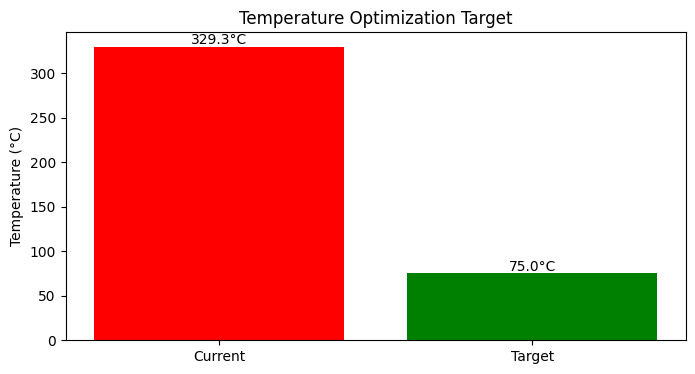


Full result details:
{
  "status": "optimize",
  "message": "Initialization failed",
  "predicted_temp": 329.31272644452287,
  "action": "optimize",
  "suggested_params": {
    "aspect_ratio": 0.10072803294837254,
    "liquid_frac": 1999.9999449045015,
    "Nu": 0.10000843613809411
  },
  "timestamp": "2025-07-23T06:42:31.819123"
}


In [11]:
# First, add these imports at the top of your notebook if not already present
import json
import datetime
import numpy as np
import matplotlib.pyplot as plt

# Then use this fixed version of the hybrid system code:

try:
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    print("Pre-trained model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {str(e)}")
    print("Training a dummy model for demonstration purposes...")

    class DummyModel(nn.Module):
        def __init__(self, input_size):
            super().__init__()
            self.fc = nn.Sequential(
                nn.Linear(input_size, 32),
                nn.ReLU(),
                nn.Linear(32, 1))

        def forward(self, x):
            if x.dim() == 3:
                x = x[:, -1, :]
            return self.fc(x)

    dummy_model = DummyModel(input_size=X_train.shape[-1]).to(device)
    optimizer = torch.optim.Adam(dummy_model.parameters(), lr=0.01)

    for epoch in range(5):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = dummy_model(batch_X)
            loss = F.mse_loss(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(f"Dummy training epoch {epoch+1}, Loss: {loss.item():.4f}")

    model = dummy_model
    print("Dummy model trained.")

def get_lstm_prediction(input_features, model, norm_stats):
    try:
        X_mean, X_std = norm_stats[0], norm_stats[1]
        y_mean, y_std = norm_stats[2], norm_stats[3]

        if isinstance(input_features, (list, tuple)):
            input_features = np.array(input_features)

        input_norm = (input_features - X_mean) / (X_std + 1e-8)

        if input_norm.ndim == 1:
            input_norm = input_norm.reshape(1, 1, -1)
        elif input_norm.ndim == 2:
            input_norm = input_norm.reshape(1, *input_norm.shape)

        input_tensor = torch.tensor(input_norm, dtype=torch.float32).to(device)

        with torch.no_grad():
            prediction_norm = model(input_tensor).cpu().numpy()

        return (prediction_norm * y_std + y_mean).item()

    except Exception as e:
        print(f"Prediction error: {str(e)}")
        return None

def get_optimized_parameters(model, X_train_opt, y_train_opt):
    try:
        problem = BatteryCoolingProblem(
            model,
            torch.tensor(X_train_opt, dtype=torch.float32),
            torch.tensor(y_train_opt, dtype=torch.float32)
        )

        algorithm = NSGA2(
            pop_size=20,
            n_offsprings=10,
            eliminate_duplicates=True
        )

        res = minimize(problem, algorithm, ('n_gen', 50), seed=42, verbose=False)

        if res.X is not None and len(res.X) > 0:
            return res.X[0]

    except Exception as e:
        print(f"Optimization error: {str(e)}")

    return np.array([0.3, 1500.0, 0.5])

def run_hybrid_system(current_data, model, norm_stats, X_train_opt=None, y_train_opt=None,
                     threshold=75.0, verbose=True):
    result = {
        'status': 'error',
        'message': 'Initialization failed',
        'predicted_temp': None,
        'action': None,
        'suggested_params': None,
        'timestamp': datetime.datetime.now().isoformat()
    }

    try:
        if current_data is None:
            raise ValueError("No input data provided")

        current_data = np.array(current_data)
        if current_data.size == 0:
            raise ValueError("Empty input data")

        if current_data.ndim == 1:
            current_data = current_data.reshape(1, -1)
        elif current_data.ndim == 3:
            current_data = current_data[0]

        pred_temp = get_lstm_prediction(current_data, model, norm_stats)
        if pred_temp is None:
            raise RuntimeError("Prediction failed")

        result.update({
            'predicted_temp': pred_temp,
            'status': 'monitor',
            'action': 'monitor'
        })

        if verbose:
            print(f"\nCurrent predicted temperature: {pred_temp:.2f}°C")

        if pred_temp > threshold:
            if verbose:
                print(f"Temperature exceeds {threshold}°C - triggering optimization")

            if X_train_opt is None or y_train_opt is None:
                raise ValueError("Missing optimization training data")

            params = get_optimized_parameters(model, X_train_opt, y_train_opt)
            if params is None:
                raise RuntimeError("Optimization failed")

            result.update({
                'status': 'optimize',
                'action': 'optimize',
                'suggested_params': {
                    'aspect_ratio': float(params[0]),
                    'liquid_frac': float(params[1]),
                    'Nu': float(params[2])
                }
            })

            if verbose:
                print("Suggested parameters:", result['suggested_params'])

        return result

    except Exception as e:
        result.update({
            'message': str(e)
        })
        return result

# Example Usage
print("\n" + "="*60)
print(" Running Hybrid System Example ".center(60))
print("="*60)

if '0.4' in datasets:
    X_train_04, X_test_04, y_train_04, y_test_04, stats_04 = datasets['0.4']

    # Take first sequence from test set and denormalize
    sample_data = X_test_04[0]  # Shape: (seq_len, n_features)
    sample_denorm = (sample_data * stats_04[1]) + stats_04[0]

    # Run hybrid system
    result = run_hybrid_system(
        current_data=sample_denorm,
        model=model,
        norm_stats=stats_04,
        X_train_opt=X_train_04,
        y_train_opt=y_train_04,
        threshold=75.0
    )

    # Print results in a readable format
    print("\nHybrid System Results:")
    print("-"*40)
    print(f"Status: {result['status']}")
    print(f"Predicted Temperature: {result['predicted_temp']:.2f}°C")

    if result['status'] == 'optimize':
        print("\nOptimization Suggested:")
        for param, value in result['suggested_params'].items():
            print(f"{param}: {value:.4f}")

        # Simple visualization
        plt.figure(figsize=(8, 4))
        bars = plt.bar(['Current', 'Target'],
                      [result['predicted_temp'], 75.0],
                      color=['red', 'green'])
        plt.ylabel('Temperature (°C)')
        plt.title('Temperature Optimization Target')
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}°C',
                    ha='center', va='bottom')
        plt.show()
    else:
        print("\nNo optimization needed - temperature within safe limits")

    print("\nFull result details:")
    print(json.dumps(result, indent=2))
else:
    print("\nCould not run example - missing '0.4' dataset")

Error Analysis :


               Running Hybrid System Example                

--------------------
Evaluating Aspect Ratio 0.3
--------------------


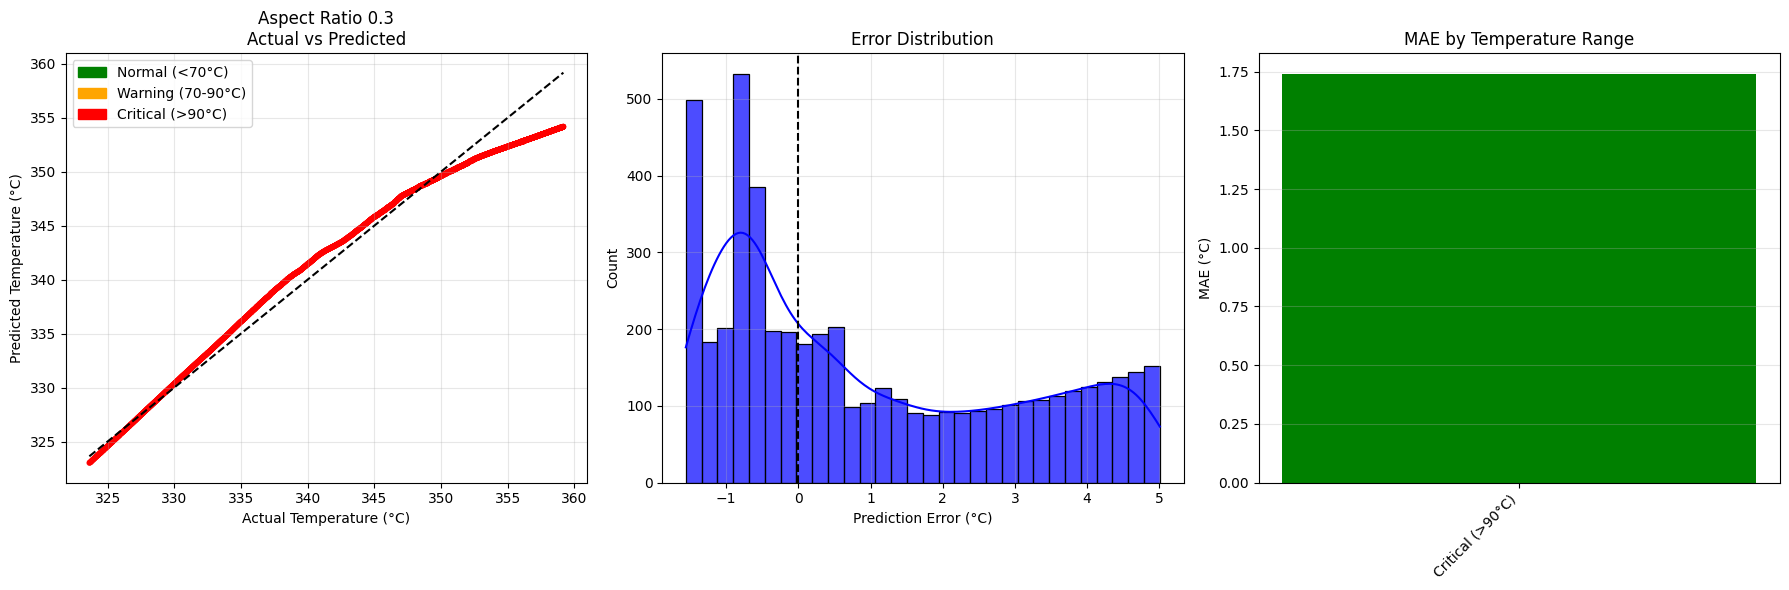


           LSTM Model Metrics (Aspect Ratio 0.3)            
Mae: 1.7421
Rmse: 2.2645
R2: 0.9487
Max Error: 5.0098

Range Metrics:
  Critical (>90°C): MAE=1.74, Samples=4990

Threshold Metrics:

--------------------
Evaluating Aspect Ratio 0.4
--------------------


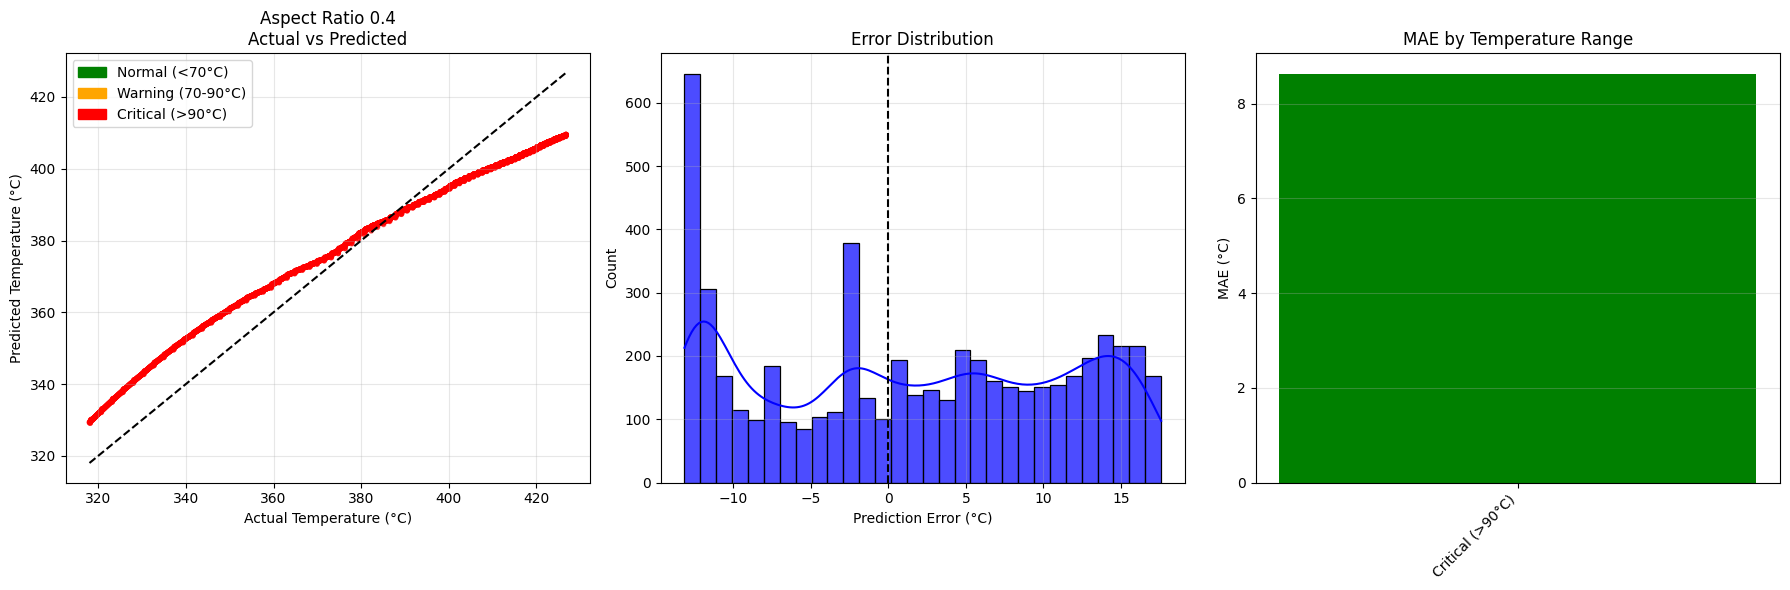


           LSTM Model Metrics (Aspect Ratio 0.4)            
Mae: 8.6347
Rmse: 9.8900
R2: 0.8979
Max Error: 17.5916

Range Metrics:
  Critical (>90°C): MAE=8.63, Samples=5490

Threshold Metrics:

--------------------
Evaluating Aspect Ratio 0.5
--------------------


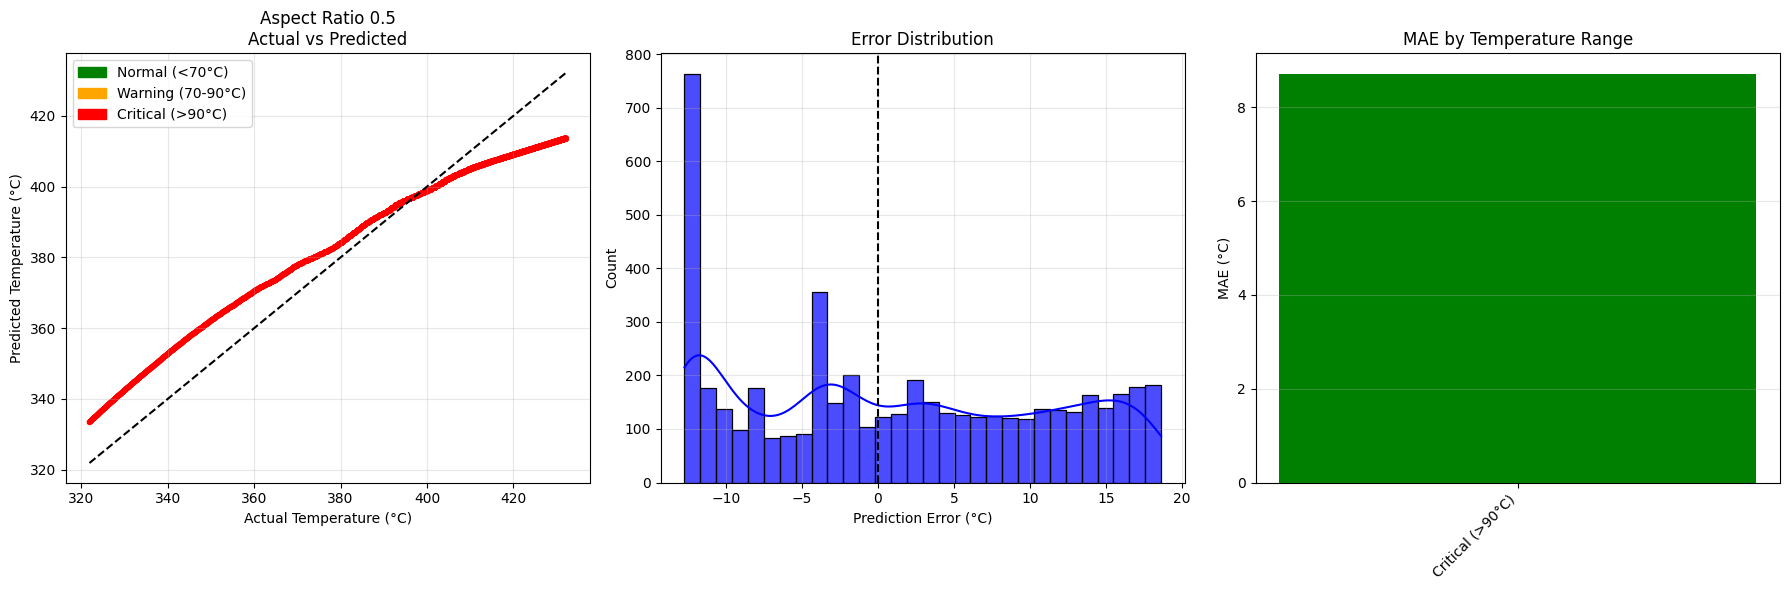


           LSTM Model Metrics (Aspect Ratio 0.5)            
Mae: 8.7209
Rmse: 10.0748
R2: 0.8958
Max Error: 18.6404

Range Metrics:
  Critical (>90°C): MAE=8.72, Samples=4990

Threshold Metrics:

          Running a Sample Hybrid System Scenario           

Current predicted temperature: -14775503.07°C
Hybrid system response: {'status': 'monitor', 'message': 'Initialization failed', 'predicted_temp': -14775503.073972177, 'action': 'monitor', 'suggested_params': None, 'timestamp': '2025-07-23T06:43:20.037038'}


In [12]:
print("\n" + "="*60)
print(" Running Hybrid System Example ".center(60))
print("="*60)

# Evaluate the trained LSTM model on a full test set for all available aspect ratios
for ar, data_tuple in datasets.items():
    X_train_ar, X_test_ar, y_train_ar, y_test_ar, norm_stats_ar = data_tuple
    print(f"\n{'-'*20}\nEvaluating Aspect Ratio {ar}\n{'-'*20}")
    lstm_metrics_ar = evaluate_model(model, X_test_ar, y_test_ar, norm_stats_ar, ar)
    print("\n" + "="*60)
    print(f" LSTM Model Metrics (Aspect Ratio {ar}) ".center(60))
    print("="*60)
    for key, value in lstm_metrics_ar['overall'].items():
        print(f"{key.replace('_', ' ').title()}: {value:.4f}")
    print("\nRange Metrics:")
    for r_name, r_metrics in lstm_metrics_ar['ranges'].items():
        print(f"  {r_name}: MAE={r_metrics['mae']:.2f}, Samples={r_metrics['samples']}")
    print("\nThreshold Metrics:")
    for t_name, t_metrics in lstm_metrics_ar['thresholds'].items():
        print(f"  {t_name.replace('threshold_', 'Thresh ')}: F1={t_metrics['f1']:.2f}, Precision={t_metrics['precision']:.2f}, Recall={t_metrics['recall']:.2f}, Accuracy={t_metrics['accuracy']:.2f}")

print("\n" + "="*60)
print(" Running a Sample Hybrid System Scenario ".center(60))
print("="*60)

# Example scenario: use a sample from the test data to simulate a "current" state
# We'll use data from aspect ratio 0.4 for this example, if available.
if '0.4' in datasets:
    sample_index = 0
    # Denormalize a sample from X_test_04 to represent a real-world input
    X_train_04, X_test_04, y_train_04, y_test_04, norm_stats_04 = datasets['0.4']
    sample_current_data_norm = X_test_04[sample_index] # Use normalized data directly from X_test

    # Run the hybrid system
    hybrid_result = run_hybrid_system(sample_current_data_norm, model, norm_stats_04, X_train_04, y_train_04)
    print(f"Hybrid system response: {hybrid_result}")
else:
    print("\nCannot run hybrid system example as Aspect Ratio 0.4 data is not available.")

# You can repeat the hybrid system run with different thresholds or data points
# to observe its behavior.

In [ ]:
# # Replace the non-working cell with this corrected version:

# # Get denormalized test predictions first
# with torch.no_grad():
#     y_pred = model(torch.tensor(X_test, dtype=torch.float32)).numpy()

# # Denormalize
# y_mean, y_std = norm_stats[2], norm_stats[3]
# y_test_actual = (y_test * y_std + y_mean).flatten()
# y_pred_actual = (y_pred * y_std + y_mean).flatten()

# # Define critical temperature thresholds (using C5 battery max of 70°C)
# critical_threshold = 70  # Maximum operating temperature
# warning_threshold = 65   # Warning level (5°C below max)
# safety_margin = 5        # Degrees below max for safety buffer

# # Convert to binary classes
# Y_test_class = (y_test_actual > critical_threshold).astype(int)
# Y_pred_class = (y_pred_actual > critical_threshold).astype(int)

In [ ]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# def calculate_classification_metrics(y_true, y_pred):
#     metrics = {
#         'accuracy': accuracy_score(y_true, y_pred),
#         'precision': precision_score(y_true, y_pred, zero_division=0),
#         'recall': recall_score(y_true, y_pred, zero_division=0),
#         'f1': f1_score(y_true, y_pred, zero_division=0)
#     }

#     # Confusion matrix
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(6,6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#                 xticklabels=['Normal', 'Overheat'],
#                 yticklabels=['Normal', 'Overheat'])
#     plt.title('Confusion Matrix')
#     plt.show()

#     return metrics

In [ ]:
# def evaluate_classification(model, X_test, y_test, norm_stats, threshold):
#     # Get predictions
#     with torch.no_grad():
#         y_pred = model(torch.tensor(X_test, dtype=torch.float32)).numpy()

#     # Denormalize
#     y_mean, y_std = norm_stats[2], norm_stats[3]
#     y_test_actual = (y_test * y_std + y_mean).flatten()
#     y_pred_actual = (y_pred * y_std + y_mean).flatten()

#     # Convert to classes
#     y_test_class = (y_test_actual > threshold).astype(int)
#     y_pred_class = (y_pred_actual > threshold).astype(int)

#     # Only calculate if both classes exist
#     if len(np.unique(y_test_class)) > 1:
#         return calculate_classification_metrics(y_test_class, y_pred_class)
#     else:
#         print(f"Warning: Only one class present at threshold {threshold}°C")
#         return None

# # Example usage
# critical_metrics = evaluate_classification(model, X_test, y_test, norm_stats, critical_threshold)
# warning_metrics = evaluate_classification(model, X_test, y_test, norm_stats, warning_threshold)

# if critical_metrics:
#     print("\nCritical Threshold Metrics:")
#     print(f"Accuracy: {critical_metrics['accuracy']:.2f}")
#     print(f"Precision: {critical_metrics['precision']:.2f}")
#     print(f"Recall: {critical_metrics['recall']:.2f}")
#     print(f"F1 Score: {critical_metrics['f1']:.2f}")

In [ ]:
# import seaborn as sns
# thresholds = np.linspace(y_test_actual.min(), y_test_actual.max(), 20)
# results = []

# for thresh in thresholds:
#     metrics = evaluate_classification(model, X_test, y_test, norm_stats, thresh)
#     if metrics:
#         results.append({
#             'threshold': thresh,
#             **metrics
#         })

# # Plot results
# if results:
#     results_df = pd.DataFrame(results)
#     plt.figure(figsize=(10,5))
#     plt.plot(results_df['threshold'], results_df['f1'], label='F1 Score')
#     plt.plot(results_df['threshold'], results_df['accuracy'], label='Accuracy')
#     plt.xlabel('Temperature Threshold (°C)')
#     plt.ylabel('Score')
#     plt.legend()
#     plt.title('Threshold Sensitivity Analysis')
#     plt.show()